# Project 2 part 1

### Catalina Jaramillo 
### Angelica Narvaes

In [1]:
import numpy as np
from scipy.io import loadmat
import copy
from scipy import optimize
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#import matrix

mat = loadmat("ex3data1.mat")
X = mat["X"]
y = mat["y"]

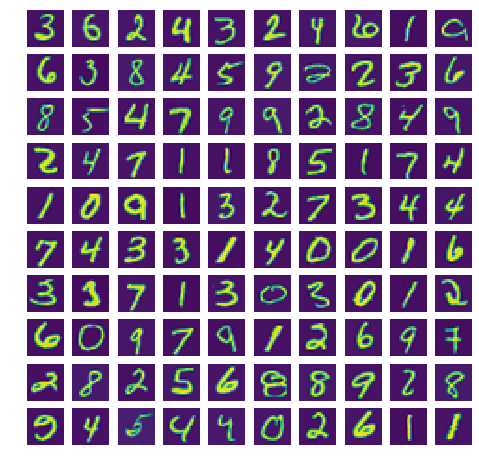

In [3]:
fig,axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,5000),:].reshape(20,20,order="F"))
        axis[i,j].axis("off")

In [4]:
# sigmoid function

def sigmoid(z):
    return 1/(1+np.exp(-z))

In [5]:
# Derivative of sigmoid function

def sigmoidGradient(z):
    sigmoid = 1/(1+np.exp(-z))
    return sigmoid*(1-sigmoid)

In [6]:
# Random initial weights of theta

def randInitializeWeights(L_in,L_out):
    epi = (2**(1/2))/(L_in+L_out)**(1/2)
    # Recall the matrix is like in the other sense and we need to add the bais weight
    W = np.random.rand(L_out,L_in+1)*(2*epi)-epi
    return W

In [7]:
# initial values of theta

def initialTheta(input_layer_size, hidden_layer_size,num_labels):
    theta = []
    if type(hidden_layer_size)== int:
        theta.append(randInitializeWeights(input_layer_size,hidden_layer_size))
        theta.append(randInitializeWeights(hidden_layer_size,num_labels))
    else:
        k = len(hidden_layer_size)
        for i in range(k+1):
            if i==0:
                theta.append(randInitializeWeights(input_layer_size, hidden_layer_size[0]))
            elif i== k:
                theta.append(randInitializeWeights(hidden_layer_size[k-1], num_labels))
            else:
                theta.append(randInitializeWeights(hidden_layer_size[i-1],hidden_layer_size[i]))
    return theta

In [8]:
# theta list as a flatten vector

def flattenTheta(thetai, input_layer_size, hidden_layer_size, num_labels):
    for i in range(len(thetai)):
        if i==0:
            theta = thetai[i].flatten()
        else:
            theta = np.insert(theta, len(theta), thetai[i].flatten())
            
    
    return theta


In [9]:
# theta as a list

def listTheta(thetai, input_layer_size, hidden_layer_size, num_labels):
    
    theta = []
    
    aux = 0
     
    # if there is only 1 hidden layer
    if type(hidden_layer_size)==int:
        theta.append(thetai[:((input_layer_size+1)*hidden_layer_size)].reshape(hidden_layer_size, input_layer_size+1))
        theta.append(thetai[((input_layer_size+1)*hidden_layer_size):].reshape(num_labels, hidden_layer_size+1))
        return theta
    else:   
        l=len(hidden_layer_size)
        
    # if there is more than 1 hidden layer    
    for i in range(l+1):
        if i==0:
            aux = (input_layer_size+1)*hidden_layer_size[i]
            theta.append(thetai[:aux].reshape(hidden_layer_size[i], input_layer_size+1))
        elif i==l:
            aux1= copy.deepcopy(aux)
            aux = aux + (hidden_layer_size[i-1]+1)*num_labels
            theta.append(thetai[aux1:aux].reshape(num_labels, hidden_layer_size[i-1]+1))
        elif i>0 and i<l:
            aux1= copy.deepcopy(aux)
            aux = aux + (hidden_layer_size[i-1]+1)*(hidden_layer_size[i])
            theta.append(thetai[aux1:aux].reshape(hidden_layer_size[i], hidden_layer_size[i-1]+1))

    return theta

In [10]:
# Generalize cost function for any number of hidden layers. Input as a list. A single hidden layer could be as an integer

def computeCost(thetai,X,y,input_layer_size, hidden_layer_size, num_labels, Lambda):
                   
    theta = listTheta(thetai, input_layer_size, hidden_layer_size, num_labels)
    l=len(theta)
    
    m = X.shape[0]
    # number of layers
    
    J = 0
    
    #join the vector of 1s
    
    X = np.hstack((np.ones([m,1]),X))
    y10 = np.zeros([m,num_labels])
    
    #Activation list
    a=[]

    for i in range(l):
        #1st activation
        if i==0:
            a1 = sigmoid(X @ theta[i].T)
            a1 = np.hstack((np.ones([m,1]),a1))
            a.append(a1)
       
        #final activation
        elif i==l-1:
            a2 = sigmoid(a[i-1] @ theta[i].T)
            a.append(a2)
            
        #hidden activation
        else:
            a1 = sigmoid(a[i-1] @ theta[i].T)
            a1 = np.hstack((np.ones([m,1]),a1))
            a.append(a1)

                
    for i in range(1,num_labels+1):
        #creates the matrix of ys, where each column is the vector of label, with 1 in position i if class=i
    
        ''' np.newaxis might come in handy when you want to explicitly convert a 1D array to 
            either a row vector or a column vector.
        '''
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
        
    for j in range(num_labels):
        #adding all log cost function
        J = J - np.sum(y10[:,j]*np.log(a[l-1][:,j])+(1-y10[:,j])*np.log(1-a[l-1][:,j]))
        
    cost = (1/m)*J
    
    #regularized cost for logistic regression
    regj = 0
    # derivatives for each layer  
    grad = []
    for i in range(l):
        regj = regj+np.sum(theta[i][:,1:]**2)   ####CHECK IF IT CAN BE CHANGED TO DOT PRODUCT.
        grad.append(np.zeros((theta[i].shape)))
      
    reg_J = cost + Lambda/(2*m)*(regj)
            
    #computing update of thetas
    for i in range(m):
        xi = X[i,:]
        
        #activation i
        ai= []
        ai.append(xi)
        
        for j in range(l):
            ai.append(a[j][i,:])
       
        # deltas 
        delta = []
        #len(ai)=l+1
        for j in range(l,0,-1):
            # delta in output
            if j==l:
                # 1st delta
                delta.append(ai[j]-y10[i,:])
            
            #delta hidden layer
            
            #the case of layer L-1 is different because of bias on L-1 and not bias on output
            elif j==l-1:
                delta.append((theta[j].T @ delta[l-j-1])*(ai[j])*(1-ai[j]))
            
            else: 
                #never delta(0)
                delta.append((theta[j].T @ delta[l-j-1][1:])*(ai[j])*(1-ai[j]))
        
        # reverse delta because it's created by backpropagation
        delta.reverse()
     
        # grad = grad anterior(layer l) + delta(layer l+1)*(a(layer l))^T 
        
        #update grad
        
        for j in range(l):
            # recall ai[j] = a[j-1]... len(ai)=l+1 because a1[0]=xi
            if j==l-1:
                grad[j] = grad[j] +  delta[j].T[:,np.newaxis]@ai[j][:,np.newaxis].T
            else:
                grad[j] = grad[j] + delta[j][1:][:,np.newaxis]@ ai[j][:,np.newaxis].T

    grad_reg = []

    for i in range(l):
        grad[i] = (1/m)*grad[i]
        grad_reg.append(grad[i]+(Lambda/m)*np.hstack((np.zeros([theta[i].shape[0],1]), theta[i][:,1:])))
    

    # flatten grad_red
    for i in range (len(grad_reg)):
        if i==0:
            g1 = grad_reg[i].flatten()
        else:
            g1 = np.insert(g1, len(g1), grad_reg[i].flatten())
    
    return reg_J,g1

In [11]:
# gradient descent 

def gradientDescent(X,y,theta,alpha,n_iter, Lambda, input_layer_size, hidden_layer_size,num_labels):
    
    #l=len(theta)
    m = len(y)
    J_history = []
    
    theta_fin = copy.deepcopy(theta)
    
    for i in range(n_iter):
        #to take the regularized cost and reg gradients
        
        cost, grad = computeCost(theta_fin,X,y,input_layer_size,hidden_layer_size,num_labels,Lambda)
        theta_fin = theta_fin-(alpha*grad)        
        J_history.append(cost)
        
    theta = listTheta(theta_fin, input_layer_size, hidden_layer_size, num_labels)

    
    return theta,J_history

In [12]:
def prediction(X, thetai,input_layer_size,hidden_layer_size,num_labels):
    theta = listTheta(thetai,input_layer_size,hidden_layer_size,num_labels)
    l=len(theta)
    m = X.shape[0]
    X = np.hstack((np.ones([m,1]),X))
                
    for i in range(l):
    #1st activation
        if i==0:
            a1 = sigmoid(X @ theta[i].T)
            a1 = np.hstack((np.ones([m,1]),a1))

        #final activation
        elif i==l-1:
            a2 = sigmoid(a1 @ theta[i].T)

        #hidden activation
        else:
            aux=a1
            a1 = sigmoid(aux @ theta[i].T)
            a1 = np.hstack((np.ones([m,1]),a1))
    

    # the class is the largest value (the largest probability)
    return np.argmax(a2,axis=1)+1

In [13]:
## Initialize

input_layer_size = 400
# list of hidden layers'size
hidden_layer_size = 25
num_labels = 10


initial_theta = initialTheta(input_layer_size,hidden_layer_size,num_labels)
initial_theta_flatten = flattenTheta(initial_theta, input_layer_size, hidden_layer_size, num_labels)

In [14]:
# Gradient Descent 

n_iter = 1000
alpha = 0.8
Lambda = 1

theta, J_history = gradientDescent(X,y, initial_theta_flatten, alpha ,n_iter, Lambda,input_layer_size, hidden_layer_size, num_labels)


In [15]:
# scaling matrix for values between 0 and 1
def scalingMatrix(X):
    Z = (X.min())*np.ones(X.shape)
    newX = (1/(X.max()-X.min()))*(X - Z)
    return(newX)    

### Visual representation for each activation function on first layer

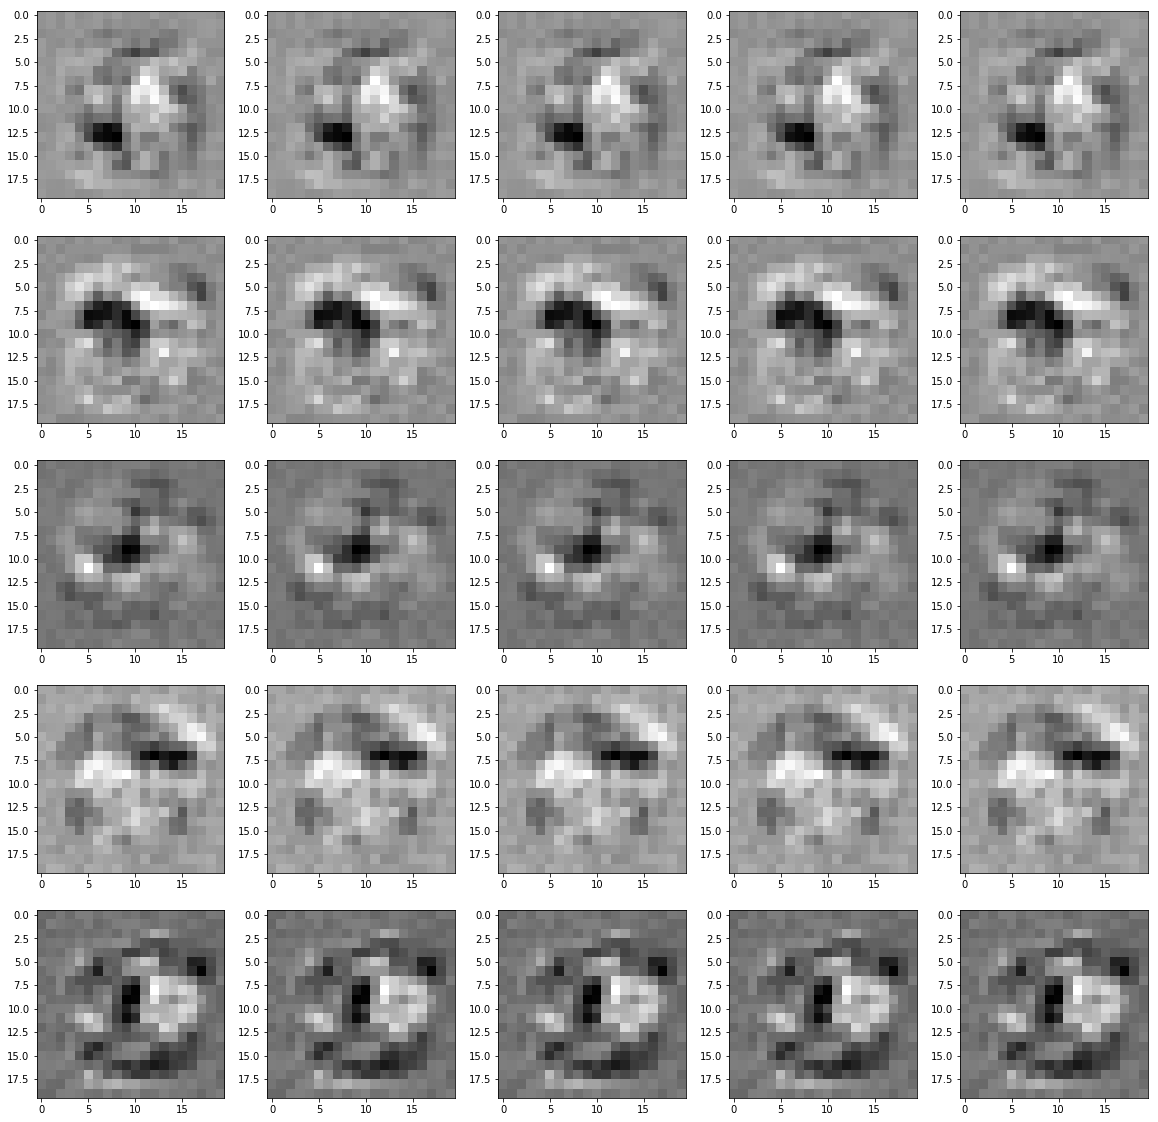

In [17]:
if (len(theta[0])%5) == 0:
    k = int(len(theta[0])/5)
else:
    k = int(len(theta[0])/5)+1

fig,axis = plt.subplots(k,5,figsize=(20,20))

for i in range(int(len(theta[0])/5)+1):
    for j in range(5):
        if 5*(i)+j+1<= len(theta[0]):
            normal_theta = copy.deepcopy(scalingMatrix(theta[0][i][1:]))
            axis[i,j].imshow(normal_theta.reshape(20,20,order="F"),cmap=plt.cm.gray)


### Prediction

In [18]:
theta_f = flattenTheta(theta,input_layer_size,hidden_layer_size,num_labels)
pred = prediction(X, theta_f,input_layer_size,hidden_layer_size,num_labels)
print("Training Set Accuracy", sum(pred[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy 95.02000000000001 %


### Wrong prediction

In [19]:
def wrongPred(pred,y):
    m = len(y)
    values = pd.DataFrame()
    for i in range(m):
        if (pred[i]-y[i])==0:
            pass
        else:
            if y[i]==10 and pred[i]==0:
                pass
            else:
                values = values.append(pd.DataFrame({'Indice':i,'Número real':y[i],'Número predito':pred[i]}))   
    values.index = range(1,len(values)+1)
    return values

df = wrongPred(pred,y)
df

,Indice,Número real,Número predito
1,112,10,3
2,142,10,8
3,265,10,4
4,316,10,3
5,351,10,7
6,392,10,6
7,505,1,3
8,509,1,2
9,521,1,4
10,531,1,7


In [21]:
# Plotting images with its actual number and wrong-predicted number

fig,axis = plt.subplots(int(len(df)/5)+1,5,figsize=(20,520))
for i in range(int(len(df)/5)+1):
    for j in range(5):
        if 5*(i)+j+1<= len(df):
            axis[i,j].imshow(X[(df['Indice'][5*(i)+j+1]),:].reshape(20,20,order="F"))
            axis[i,j].set_title((df['Número real'][5*(i)+j+1],df['Número predito'][5*(i)+j+1]),size=20)
            axis[i,j].axis("off")
        else:
            break
plt.tight_layout()


### Confusion matrix

In [22]:
def confusionMatrix(pred,y):
    M = np.zeros([10,10])
    m = len(y)
    y = np.where(y==10,0, y) 
    for i in range(m):
        #print(y[i][0])
        if y[i][0] == 10:
            #print(y[i])
            M[0,pred[i]] = M[0,pred[i]]+1
        elif pred[i] == 10:
            #print(y[i])
            M[y[i],0] = M[y[i],0]+1
        else:
            M[y[i][0],pred[i]] = M[y[i][0],pred[i]]+1
    return M

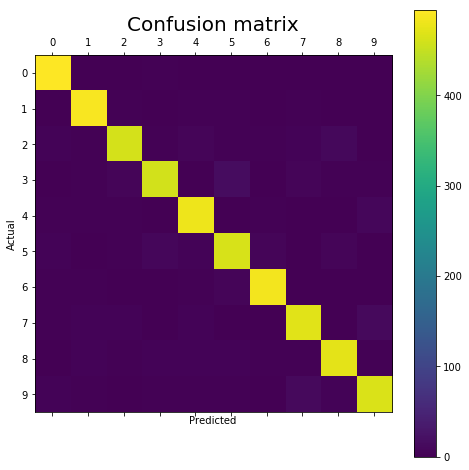

In [24]:
M = confusionMatrix(pred,y)

plt.rc('figure', figsize=(8, 8))
plt.matshow(M);
plt.colorbar()
plt.title('Confusion matrix',size=20)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(range(0,10))
plt.yticks(range(0,10))
plt.show()

# Comparison with Python's function of gradient descendent

In [25]:
Lambda = 0.3

args = (X,y, input_layer_size, hidden_layer_size, num_labels, Lambda)


res = optimize.minimize(computeCost, initial_theta_flatten, args=args, method='CG', options={'maxiter':400,'disp':True}, jac=True)

         Current function value: 0.151145
         Iterations: 400
         Function evaluations: 1109
         Gradient evaluations: 1109


### Prediction 

In [26]:
theta2 = res.x
pred2 = prediction(X, theta2, input_layer_size,hidden_layer_size,num_labels)
print("Training Set Accuracy", sum(pred2[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy 100.0 %


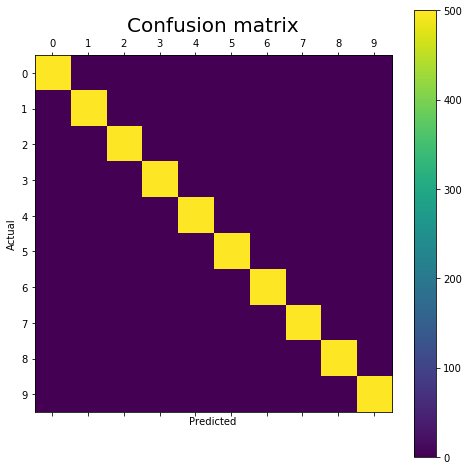

In [27]:
# The position i,j means: Actual value i predicted as j

#pred = vectorPrediction(X,listTheta(theta2,input_layer_size,hidden_layer_size,num_labels))
M = confusionMatrix(pred2,y)

plt.rc('figure', figsize=(8, 8))
plt.matshow(M);
plt.colorbar()
plt.title('Confusion matrix',size=20)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(range(0,10))
plt.yticks(range(0,10))
plt.show()

### Plotting images with its actual number and wrong-predicted number

In [28]:
# DataFrame of wrong-predicted numbers for Python library

df2 = wrongPred(pred2,y)


fig,axis = plt.subplots(int(len(df2)/5),5,figsize=(20,20))
for i in range(int(len(df2)/5)+1):
    for j in range(5):
        if 5*(i)+j+1<= len(df2):
            axis[i,j].imshow(X[(df2['Indice'][5*(i)+j+1]),:].reshape(20,20,order="F"),cmap=plt.cm.gray)
            axis[i,j].set_title((df2['Número real'][5*(i)+j+1],df2['Número predito'][5*(i)+j+1]),size=30)
            axis[i,j].axis("off")
        else:
            break
plt.tight_layout()
#fig.suptitle('(Actual number, predicted number)',fontsize=16)
plt.show()


<Figure size 1440x1440 with 0 Axes>

In [29]:
# Plotting images with its actual number and wrong-predicted number

fig,axis = plt.subplots(int(len(df2)/5)+1,5,figsize=(20,520))
for i in range(int(len(df2)/5)+1):
    for j in range(5):
        if 5*(i)+j+1<= len(df2):
            axis[i,j].imshow(X[(df2['Indice'][5*(i)+j+1]),:].reshape(20,20,order="F"), cmap=plt.cm.gray)
            axis[i,j].set_title((df2['Número real'][5*(i)+j+1],df2['Número predito'][5*(i)+j+1]),size=20)
            axis[i,j].axis("off")
        else:
            break
plt.tight_layout()
